In [108]:
#data read from input file 
import numpy as np
import pandas as pd
from scipy import stats


input_test_file='data/Pricing_Test/test_results.csv'
input_user_file='data/Pricing_Test//user_table.csv'
testdata=pd.read_csv(input_test_file)
userdata=pd.read_csv(input_user_file)

In [7]:
testdata.head()
#testdata.groupby("price").size()

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0


In [14]:
userdata.head()
#userdata.groupby("city").size()#all users are in USA, in different cities 


,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68


In [22]:
#check uniqueness of user id in both table
max(testdata.groupby("user_id").size())
max(userdata.groupby("user_id").size())

1

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

In [67]:
data=testdata.merge(userdata,how="left",on="user_id")

In [24]:
data.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,Buffalo,USA,42.89,-78.86
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,Lakeville,USA,44.68,-93.24
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,Parma,USA,41.38,-81.73
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,Fayetteville,USA,35.07,-78.90
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,Fishers,USA,39.95,-86.02


In [26]:
#data validation
data.groupby(["test","price"]).size()

test  price
0     39       202517
      59          210
1     39          155
      59       113918
dtype: int64

In [118]:
#remove records with inconsistent labels 
data=data[((data["test"]==1)&(data["price"]==59))|((data["test"]==0)&(data["price"]==39))]
data["Rev"]=data["price"]*data["converted"]

data1=data #used as data acrhive
data=data1 #change data back to all records 

#data.groupby(["test","price"]).size()

In [56]:
data1.groupby("operative_system").size()
data=data1[data1["operative_system"]=="iOS"]#checking for iOS, if different is significant or not 

In [57]:
data_low=data[data["test"]==0]
data_high=data[data["test"]==1]
data_low.head()
data_high.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long,Rev
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,Fayetteville,USA,35.07,-78.90,0
18,599771,2015-03-28 18:41:37,direct_traffic,mobile,iOS,1,59,0,Chicago,USA,41.84,-87.68,0
25,418796,2015-03-28 11:33:35,ads-yahoo,mobile,iOS,1,59,0,Johnson City,USA,36.33,-82.37,0
29,227627,2015-03-15 08:34:28,ads_facebook,mobile,iOS,1,59,0,Redding,USA,40.57,-122.36,0
35,553714,2015-03-19 19:37:08,seo-google,mobile,iOS,1,59,0,West Sacramento,USA,38.56,-121.55,0


In [107]:
print(data[["test","converted"]].groupby("test").mean())
stats.ttest_ind(data_low["converted"],data_high["converted"])

#diff is significant, then reject null hypothesis 
#accept alternative hypothesis, which is when raising price, convert ratio will be lower

      converted
test           
0      0.019904
1      0.015543


AttributeError: 'float' object has no attribute 'ttest_ind'

In [59]:
print(data[["test","Rev"]].groupby("test").mean())
stats.ttest_ind(data_low["Rev"],data_high["Rev"])
#diff is significant 

           Rev
test          
0     0.920201
1     1.179648


Ttest_indResult(statistic=-5.5980012354205906, pvalue=2.1743138932603421e-08)

In [70]:
# Check randominess
tmp = data.groupby('test')['operative_system'].apply(lambda x: x.value_counts(normalize=True)).unstack()
tmp


,windows,iOS,android,mac,other,linux
test,,,,,,
0,0.313678,0.305115,0.237807,0.080729,0.051784,0.010887
1,0.327729,0.294636,0.234280,0.076434,0.050021,0.016901


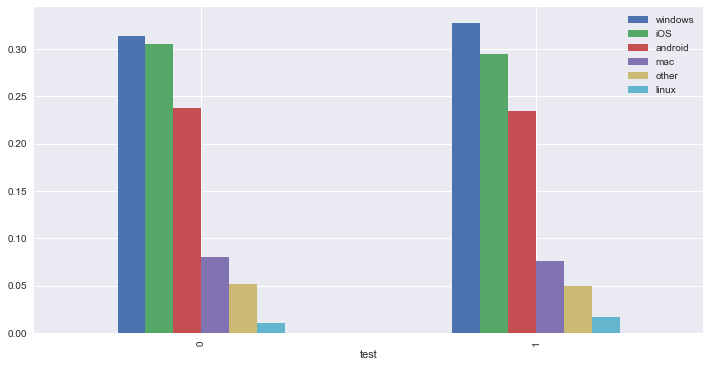

In [71]:
fig, ax = plt.subplots(figsize=(12, 6))
tmp.plot(kind='bar', ax=ax)
plt.show()

In [133]:
#question2
#how many records are enough to make a conclusion, or how many of days this experiment should run

from datetime import datetime  
from datetime import timedelta  

#date conversion from string to 
start=datetime.strptime((data["timestamp"].min()), '%Y-%m-%d %H:%M:%S')#min=2015-3-2, max=2015-5-31




#use a loop to calculate number of days 
for i in range(12):
    #print(i)    
    cutoff=start+timedelta(days=i)    
    data_tmp=data[data["timestamp"]<=cutoff.strftime("%Y-%m-%d %H:%M:%S")]
    #print(data_tmp["timestamp"].max())
     
    data_low=data_tmp[data_tmp["test"]==0]
    data_high=data_tmp[data_tmp["test"]==1]
    
    #stats,pvalue=
    pvalue=stats.ttest_ind(data_low["converted"],data_high["converted"]).pvalue
    if pvalue<0.05:
        break

print ("If I need to confirm test group conversion is lower, i need p values <0.05, I need minimal {0} days, with p value equal to={1}".format(str(j),"{:.2%}".format(pvalue)))

for j in range(10):     
    cutoff=start+timedelta(days=j)    
    data_tmp=data[data["timestamp"]<=cutoff.strftime("%Y-%m-%d %H:%M:%S")]
     
    data_low=data_tmp[data_tmp["test"]==0]
    data_high=data_tmp[data_tmp["test"]==1]
    
    pvalue=stats.ttest_ind(data_low["Rev"],data_high["Rev"]).pvalue
    if pvalue<0.05:
        break

print ("If I need to confirm test group rev is higher, i need p values <0.05, I need minimal {0} days, with p value equal to={1}".format(str(j),"{:.2%}".format(pvalue)))
 




If I need to confirm test group conversion is lower, i need p values <0.05, I need minimal 6 days, with p value equal to=1.70%
If I need to confirm test group rev is higher, i need p values <0.05, I need minimal 6 days, with p value equal to=2.59%
